In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import GPy
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from tqdm import tqdm
from functools import partial

# http://krasserm.github.io/2018/03/21/bayesian-optimization/

# Expected Improvement

[derivation](http://ash-aldujaili.github.io/blog/2018/02/01/ei/)

$$\text{EI}(x) = \mathbb{E}\max(f(x^*) - f(x^+), 0)$$

$$\text{EI}(x) = (\mu(x^*) - f(x^+)) \Phi(\frac{\mu(x^*) - f(x^+)}{\sigma(x^*)}) + \sigma(x^*) \phi(\frac{\mu(x^*) - f(x^+)}{\sigma(x^*)})$$

* $\Phi$ = CDF standard normal
* $\phi$ = PDF standard normal
* $x^*$ = proposed points
* $x^+$ = current best

Numerrically unstable if $\sigma \to 0$

$$\text{EI}(x) = (\mu(x^*) - f(x^+)) \Phi(Z) + \sigma \phi(Z)$$

$$Z = \begin{cases}
    \frac{\mu(x^*) - f(x^+)}{\sigma(x^*)},& \text{if } \sigma(x^*) > 0 \\
    0,              & \text{otherwise}
\end{cases}$$

Let $\mu(x^*) - f(x^+) := \delta$.

$$Z = \begin{cases}
    \frac{\delta}{\sigma(x^*)},& \text{if } \sigma(x^*) > 0 \\
    0,              & \text{otherwise}
\end{cases}$$

$$\text{EI}(x) = (\delta) \Phi(Z) + \sigma(x^*) \phi(Z)$$

Recommendation value for $\xi = 0.01$. 


In [5]:

def select_hyperparams_random(param_ranges):
    """
    Select hyperparameters at random.
    
    Parameters
    ----------
    param_ranges : dict
        Named parameter ranges.

        Example:
        
        {
            'foo': {
                'range': [1, 10],
                'type': 'float'
            }
            'bar': {
                'range': [10, 1000],
                'type': 'int'
            }
        }

    Returns
    -------
    selection : dict
        Randomly selected hyperparameters within given boundaries.
        
        Example:
        {'foo': 4.213, 'bar': 935}

    """
    selection = {}
    for k in param_ranges:
        val = np.random.choice(
            np.linspace(*param_ranges[k]['range'], num=100)
        )

        dtype = param_ranges[k]['type']
        if dtype is 'int':
            val = int(val)
        selection[k] = val
    return selection


def expected_improvement(f, y_current, x_proposed):
    """
    Return E(max(f_proposed - f_current), 0)

    Parameters
    ----------

    f : GP predict function
    y_current : float
        Current best evaluation f(x+)
    x_proposed : np.array
        Proposal parameters. Shape: (1, 1)

    Returns
    -------
    expected_improvement : float
        E(max(f_proposed - f_current), 0)
    """
    mu, var = f(x_proposed)
    std = var ** 0.5
    delta = mu - y_current

    # x / inf = 0
    std[std == 0] = np.inf
    z = delta / std
    unit_norm = stats.norm()
    return delta * unit_norm.cdf(z) + std * unit_norm.pdf(z)



In [18]:
param_ranges = {
    'foo': {
        'range': [1, 10],
        'type': 'float'
    },
    'bar': {
        'range': [10, 1000],
        'type': 'int'
    }
}

select_hyperparams_random(param_ranges)

{'foo': 4.545454545454545, 'bar': 580}

In [263]:
class BayesOpt:
    def __init__(
        self, param_ranges, f, random_trials=5, optimization_trials=20, kernel=None
    ):
        """
        Parameters
        ----------

        param_ranges : dict
        f : function
            black box function to evaluate
        random_trials : int
            Number of random trials to run before optimization starts
        optimization_trials : int
            Number of optimization trials to run.
            Together with the random_trials this is the total budget
        kernel: GPy.kern.src.kern.Kern
            GPy kernel for the Gaussian Process.
            If None given, RBF kernel is used
        """
        self.param_ranges = param_ranges
        self.f = f
        self.random_trials = random_trials
        self.optimization_trials = optimization_trials
        self.n_trials = random_trials + optimization_trials
        self.x = np.zeros((self.n_trials, len(param_ranges)))
        self.y = np.zeros((self.n_trials, 1))

        if kernel is None:
            self.kernel = GPy.kern.RBF(
                input_dim=self.x.shape[1], variance=1, lengthscale=1
            )
        else:
            self.kernel = kernel
        self.gp = None
        self.bounds = np.array([pr["range"] for pr in param_ranges.values()])

    @property
    def best_params(self):
        """
        Select best parameters.

        Returns
        -------
        best_parameters : dict
        """
        return self._prepare_kwargs(self.x[self.y.argmax()])

    def fit(self):
        self._random_search()
        self._bayesian_search()

    def _random_search(self):
        """
        Run the random trials budget
        """
        print(f"Starting {self.random_trials} random trials...")
        for i in tqdm(range(self.random_trials)):
            hp = select_hyperparams_random(self.param_ranges)
            self.x[i] = np.array(list(hp.values()))
            self.y[i] = self.f(hp)

    def _bayesian_search(self):
        """
        Run the Bayesian Optimization budget
        """
        print(f"Starting {self.optimization_trials} optimization trials...")
        for i in tqdm(
            range(self.random_trials, self.random_trials + self.optimization_trials)
        ):
            self.x[i], self.y[i] = self._single_iter()

    def _single_iter(self, x=None):
        """
        Fit a GP and retrieve and evaluate a new
        parameter proposal.

        Returns
        -------
        out : tuple[np.array[flt], np.array[flt]]
            (x, f(x))

        """
        self._fit_gp()
        if x is None:
            x = self._new_proposal()
        y = self.f(self._prepare_kwargs(x))
        return x, y

    def _fit_gp(self, noise_var=0):
        """
        Fit a GP on the currently observed data points.

        Parameters
        ----------
        noise_var : flt
            GPY argmument noise_var
        """
        mask = self.x.sum(axis=1) != 0
        self.gp = GPy.models.GPRegression(
            self.x[mask],
            self.y[mask],
            normalizer=True,
            kernel=self.kernel,
            noise_var=noise_var,
        )
        self.gp.optimize()

    def _new_proposal(self, n=25):
        """
        Get a new parameter proposal by maximizing
        the acquisition function.

        Parameters
        ----------
        n : int
            Number of retries.
            Each new retry the optimization is
            started in another parameter location.
            This improves the chance of finding a global optimum.

        Returns
        -------
        proposal : dict
            Example:
           {'foo': 4.213, 'bar': 935}
        """

        def f(x):
            return -expected_improvement(
                f=self.gp.predict, y_current=self.y.max(), x_proposed=x[None, :]
            )

        x0 = np.random.uniform(
            low=self.bounds[:, 0], high=self.bounds[:, 1], size=(n, self.x.shape[1])
        )
        proposal = None
        best_ei = np.inf
        for x0_ in x0:
            res = optimize.minimize(f, x0_, bounds=self.bounds)
            if res.success and res.fun < best_ei:
                best_ei = res.fun
                proposal = res.x
            if np.isnan(res.fun):
                raise ValueError("NaN within bounds")
        return proposal

    def _prepare_kwargs(self, x):
        """
        Create a dictionary with named parameters
        and the proper python types.

        Parameters
        ----------
        x : np.array
            Example:
            [4.213, 935.03]

        Returns
        -------
        hyperparameters : dict

            Example:
            {'foo': 4.213, 'bar': 935}
        """
        # create hyper parameter dict
        hp = dict(zip(self.param_ranges.keys(), x))
        # cast values
        for k in self.param_ranges:
            if self.param_ranges[k]["type"] == "int":
                hp[k] = int(hp[k])
            elif self.param_ranges[k]["type"] == "float":
                hp[k] = float(hp[k])
            else:
                raise ValueError("Parameter type not known")
        return hp

# 1D

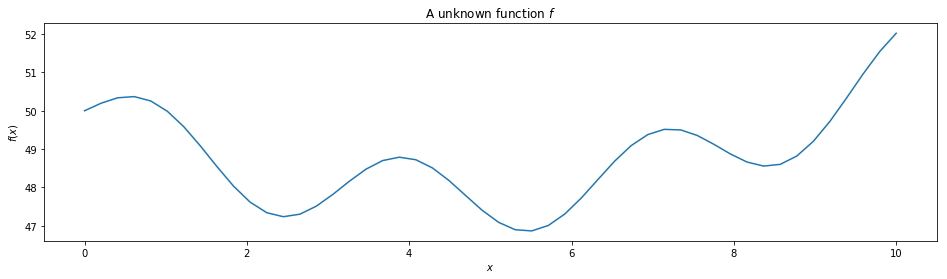

In [284]:
x = np.linspace(0, 10)

def func(x):
    return np.sin(2 * x) + (x / 3)**2 - x + 50

plt.figure(figsize=(16, 4))
plt.title('A unknown function $f$')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.plot(x, func(x))


In [259]:
def evaluate_params(hyperparams):
    return func(**hyperparams)

param_ranges = {
    'x': {
        'range': [0, 10],
        'type': 'float'
    }
}


100%|██████████| 2/2 [00:00<00:00, 2374.36it/s]

Starting 2 random trials...



 /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/rbf.py:54: RuntimeWarning:invalid value encountered in multiply
 /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square


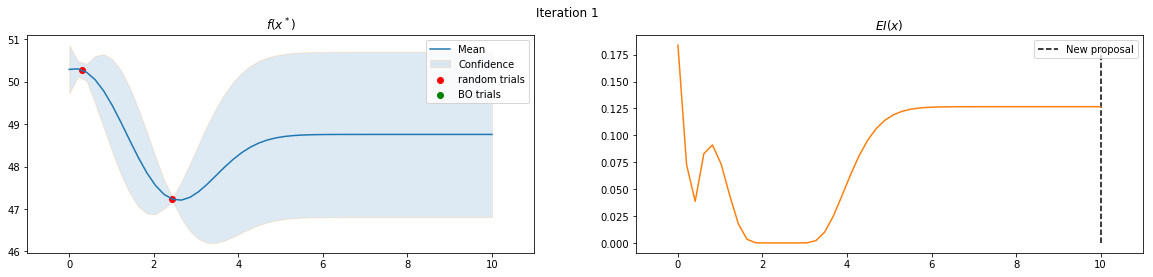

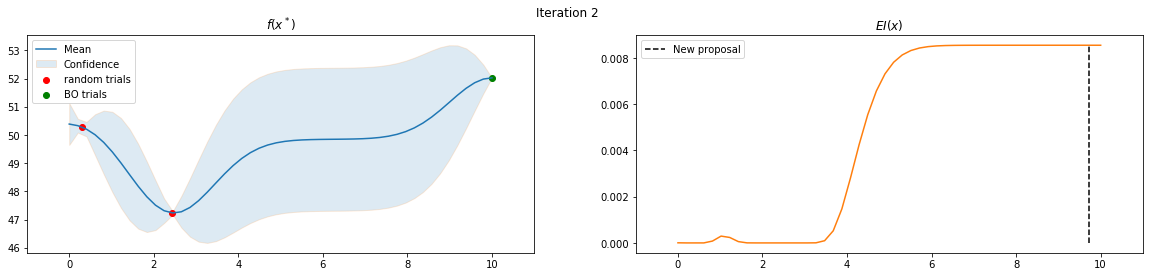

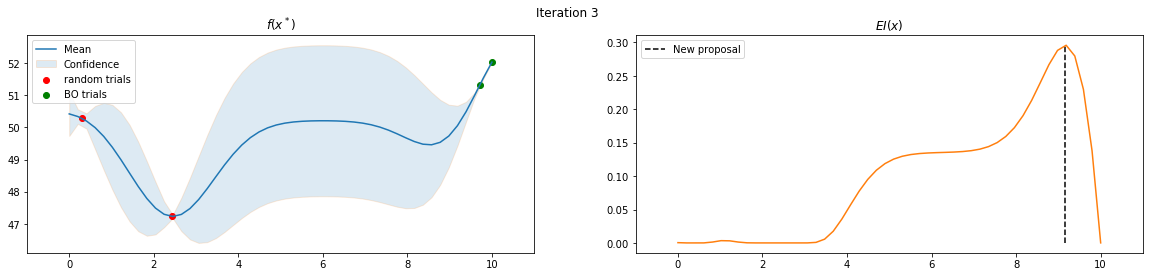

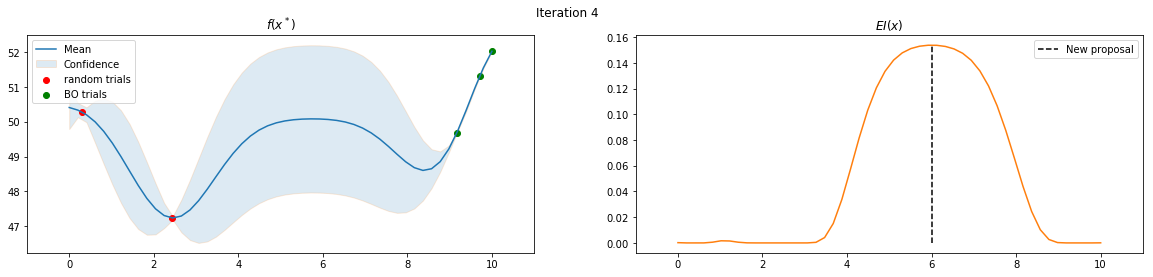

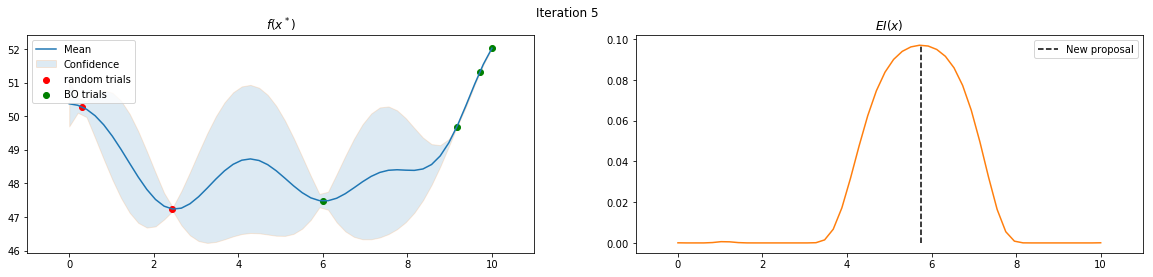

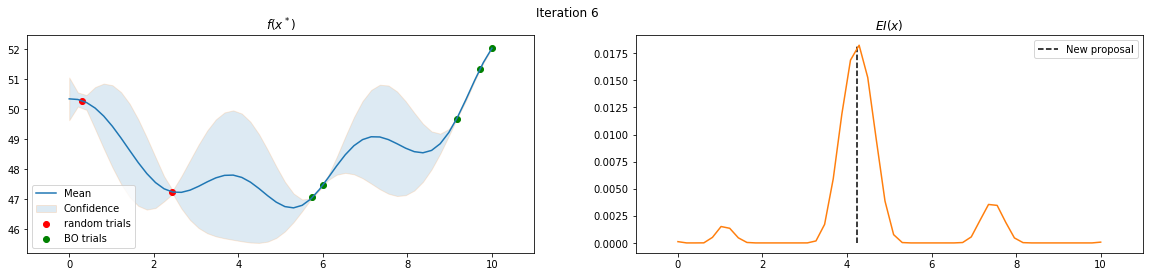

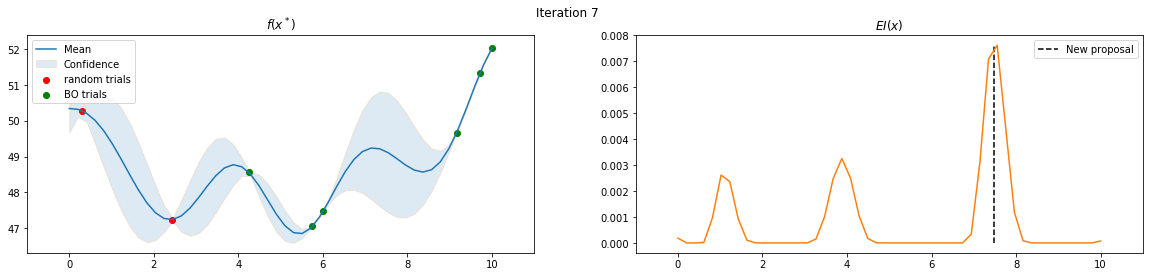

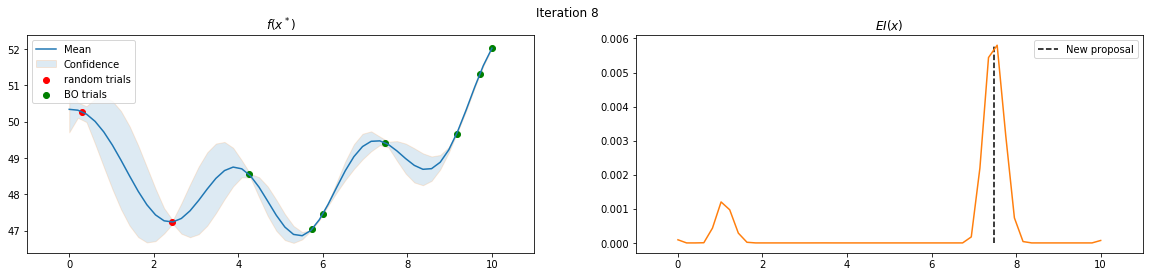

In [285]:
np.random.seed(3)
bo = BayesOpt(param_ranges, evaluate_params, random_trials=2)
bo._random_search()
bo._fit_gp()
new_proposal = bo._new_proposal()
x_, y_ = bo._single_iter(new_proposal)

for i in range(2, 10):
    new_proposal = bo._new_proposal()
    ei = expected_improvement(
        f=bo.gp.predict, y_current=bo.y.max(), x_proposed=x[:, None]
    )
    x_, y_ = bo._single_iter(new_proposal)
    bo.x[i], bo.y[i] = x_, y_

    quants = bo.gp.predict_quantiles(x[:, None], quantiles=(10, 90))
    mu, var = bo.gp.predict(x[:, None])

    plt.figure(figsize=(20, 4))
    plt.suptitle(f"Iteration {i - 1}")
    plt.subplot(1, 2, 1)
    plt.title("$f(x^*)$")
    plt.plot(x, mu, color="C0", label="Mean")
    plt.fill_between(
        x,
        quants[0].flatten(),
        quants[1].flatten(),
        alpha=0.15,
        edgecolor="C1",
        label="Confidence",
    )
    plt.scatter(
        bo.x[: bo.random_trials],
        bo.y[: bo.random_trials],
        color="r",
        label="random trials",
    )
    plt.xlim(x.min() - 1, x.max() + 1)
    mask = bo.x.sum(axis=1) != 0
    plt.scatter(
        bo.x[mask][bo.random_trials : -1],
        bo.y[mask][bo.random_trials : -1],
        color="g",
        label="BO trials",
    )

    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("$EI(x)$")
    plt.plot(x, ei, color="C1")
    plt.vlines(new_proposal, 0, ei.max(), linestyle="--", label="New proposal")
    plt.xlim(x.min() - 1, x.max() + 1)
    plt.legend()


In [234]:
bo._new_proposal()

array([5.69161243])

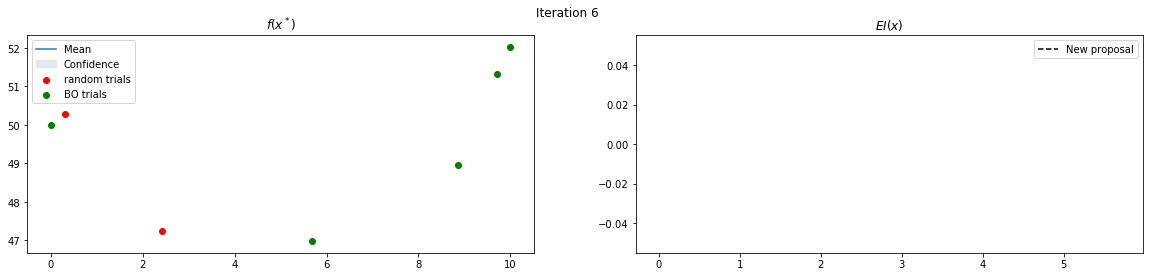

In [235]:
quants = bo.gp.predict_quantiles(x[:, None], quantiles=(10, 90))
mu, var = bo.gp.predict(x[:, None])

ei = expected_improvement(
        f=bo.gp.predict,
        y_current=bo.y.max(),
        x_proposed=x[:, None])


plt.figure(figsize=(20, 4))
plt.suptitle(f'Iteration {i}')
plt.subplot(1, 2, 1)
plt.title('$f(x^*)$')
plt.plot(x, mu, color='C0', label='Mean')
plt.fill_between(x, quants[0].flatten(), quants[1].flatten(), alpha=0.15, edgecolor='C1', label='Confidence')
plt.scatter(bo.x[:bo.random_trials], bo.y[:bo.random_trials], color='r', label='random trials')

mask = bo.x.sum(axis=1) != 0
plt.scatter(bo.x[mask][bo.random_trials:], bo.y[mask][bo.random_trials:], color='g', label='BO trials')

plt.legend()

plt.subplot(1, 2, 2)
plt.title('$EI(x)$')
plt.plot(x, ei, color='C1')
plt.vlines(bo._new_proposal(), 0, ei.max(), linestyle='--', label='New proposal')
plt.legend()

In [206]:
a = stats.multivariate_normal(mu.flatten(), cov).rvs(75)

plt.figure(figsize=(16, 4))
for i in range(a.shape[0]):
    plt.plot(x, a[i, :], alpha=0.5)

ValueError: Array 'cov' must be square if it is two dimensional, but cov.shape = (50, 1).

{'gpmean': [[<matplotlib.lines.Line2D at 0x7f9ef3c11240>],
  [<matplotlib.lines.Line2D at 0x7f9ef3abdf98>]]}

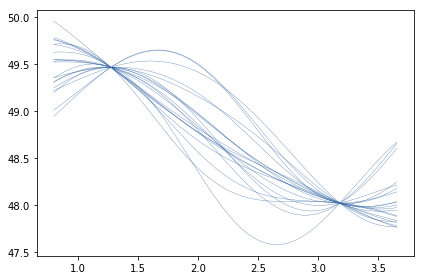

In [143]:
bo.gp.plot_samples(samples=20)

100%|██████████| 2/2 [00:00<00:00, 1279.92it/s]

Starting 2 random trials...



 /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/rbf.py:54: RuntimeWarning:invalid value encountered in multiply
 /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


 /opt/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


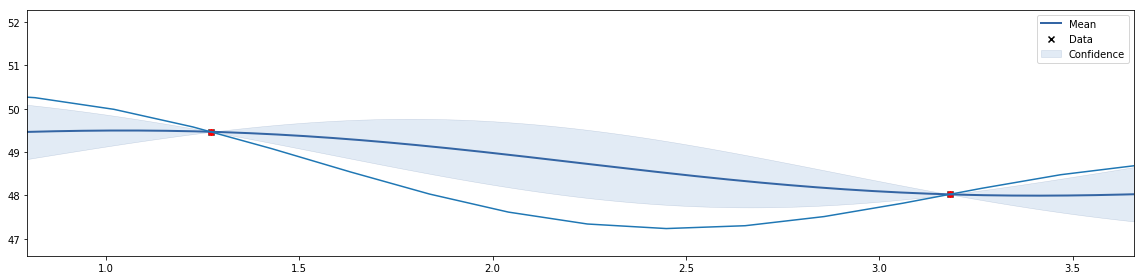

In [12]:
np.random.seed(3)
bo = BayesOpt(param_ranges, 
              evaluate_params, 
             random_trials=2)

bo._random_search()
bo._fit_gp()
bo.gp.plot(plot_density=0, figsize=(16, 4))
plt.scatter(bo.x[:bo.random_trials], bo.y[:bo.random_trials], color='r')
plt.plot(x, func(x))

  0%|          | 0/5 [00:00<?, ?it/s]

Starting 2 random trials...
Starting 5 optimization trials...


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


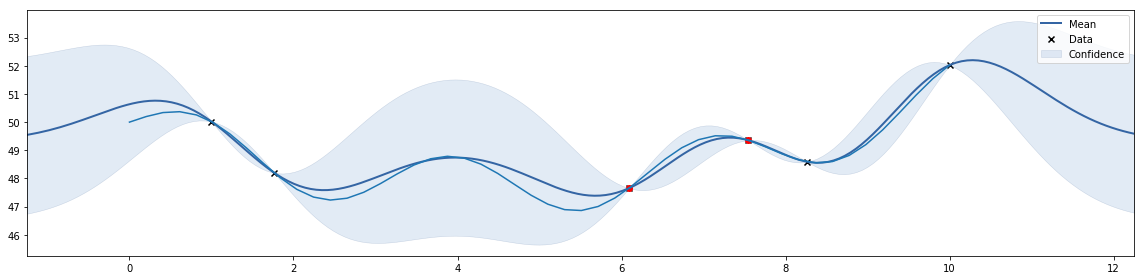

In [13]:
# np.random.seed(3)
bo = BayesOpt(param_ranges, evaluate_params, random_trials=2, optimization_trials=5)
bo.fit()
bo.gp.plot(plot_density=0, figsize=(16, 4))
plt.plot(x, func(x))
plt.scatter(bo.x[:bo.random_trials], bo.y[:bo.random_trials], color='r')

In [14]:
bo.best_params

{'x': 10.0}

In [15]:
bo._new_proposal(n=25)

array([9.82811278])

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f7eb343a908>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f7eb343a8d0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f7eb343add8>]}

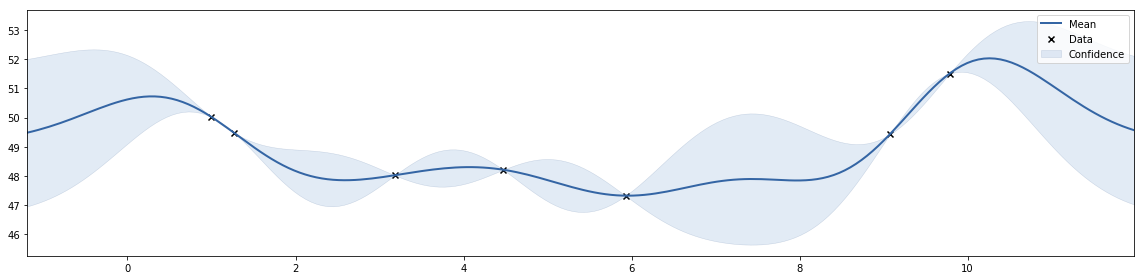

In [398]:
bo._fit_gp()
bo.gp.plot(plot_density=0, figsize=(16, 4))


In [261]:
# np.random.seed(1)
bo = BayesOpt(param_ranges, evaluate_params, xi=0.05, random_trials=10)
bo._random_search()

100%|██████████| 10/10 [00:00<00:00, 13648.89it/s]

Starting 10 random trials...


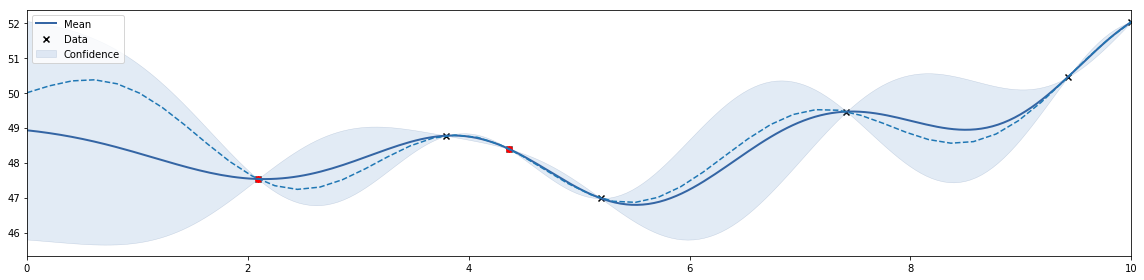

In [364]:
bo._fit_gp()
bo.gp.plot(plot_density=0, figsize=(16, 4), plot_limits=[0, 10])
plt.plot(x, func(x), ls='--')
plt.scatter(bo.x[:bo.random_trials], bo.y[:bo.random_trials], color='r')

In [356]:
bo._new_proposal(n=25)

array([1.])

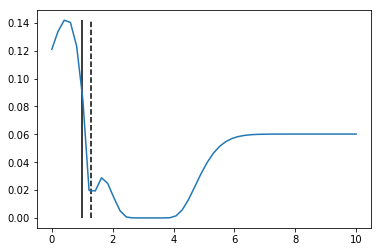

In [385]:
ei = expected_improvement(
            f=bo.gp.predict,
            y_current=bo.y.max(),
            x_proposed=x[:, None],
            xi=0
)

plt.plot(x, ei)
plt.vlines(bo._new_proposal(), 0, max(ei))
plt.vlines(bo.x[bo.y.argmax()], 0, max(ei), linestyle='--')

In [151]:
def optim_f(x):
    return -expected_improvement(
        f=bo.gp.predict,
        y_current=bo.y.max(),
        x_proposed=x[None, :],
        xi=bo.xi)


x0 = np.random.uniform(
    low=bo.bounds[:, 0],
    high=bo.bounds[:, 1],
    size=(25, bo.x.shape[1])
)
proposal = None
best_ei = np.inf
for x0_ in x0:
    res = optimize.minimize(optim_f, 
                            x0_, 
                            bounds=bo.bounds)

In [153]:
ei_along_axis([8.94396671])

array([0.05296022])

## With real data

In [2]:
fetch = fetch_openml('SpeedDating')
fetch.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
df = pd.DataFrame(fetch.data, columns=fetch.feature_names)
# make it a bit harder
df = df.drop([
    'samerace', 'sincere_important', 'age_o', 'shared_interests_important', 'pref_o_attractive', 'exercise', 'd_like', 'hiking', 'art', 'concerts', 'sports', 'pref_o_intelligence', 'pref_o_sincere', 'pref_o_ambitious', 'intellicence_important', 'pref_o_funny', 'funny_partner', 'attractive_important', 'interests_correlate', 'guess_prob_liked', 'funny_o', 'expected_num_matches', 'shared_interests_o', 'attractive_partner', 'attractive_o', 'like',
    'clubbing', 'expected_happy_with_sd_people', 'importance_same_race', 'attractive', 'ambtition_important', 'd_d_age', 'race', 'reading', 'expected_num_interested_in_me', 'd_ambitous_o', 'd_interests_correlate', 'sincere', 'intelligence', 'movies', 'd_pref_o_sincere', 'importance_same_religion', 'd_funny_partner', 'd_pref_o_attractive', 'sincere_partner', 'tvsports', 'race_o', 'museums', 'funny_important', 'gaming', 'intelligence_o', 'ambitous_o', 'd_shared_interests_o', 'sinsere_o', 'intelligence_partner', 'field', 'ambition_partner', 'd_age', 'age', 'd_guess_prob_liked', 'pref_o_shared_interests', 'd_funny_o', 'd_attractive_partner', 'd_attractive_o', 'shared_interests_partner']
, axis=1)

df.head()

,has_null,wave,gender,d_importance_same_race,d_importance_same_religion,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,d_sinsere_o,...,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,met
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
x_train, x_test, y_train, y_test = train_test_split(df, fetch.target)

In [5]:
imputer = preprocessing.Imputer(strategy='mean')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)


In [ ]:
# decision tree
param_ranges = {
    'min_samples_split': {
        'range': [2, 10],
        'type': 'int'
    },
    'min_samples_leaf': {
        'range': [1, 10],
        'type': 'int'
    },
    'max_depth': {
        'range': [3, 1000],
        'type': 'int'
    }
}

# nn
param_ranges = {
    'hidden_layer_sizes': {
        'range': [1, 10],
        'type': 'int'
    },
    'batch_size': {
        'range': [10, 100],
        'type': 'int'
    },
    'learning_rate_init': {
        'range': [0.00001, 0.01],
        'type': 'float'
    }
}

def evaluate_params(hyperparams):
    m = MLPClassifier(**hyperparams)
    m.fit(x_train, y_train)
    return m.score(x_test, y_test)